# Run SpecUFEx

================================================


1. this should be done from command


================================================

*TODO:*






================================================



In [1]:
import argparse

import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import yaml
# /src/main
from specufex import BayesianNonparametricNMF, BayesianHMM



### Load config yaml file

In [2]:
yamlPath = "/Users/theresasawi/Documents/12_Projects/sareq_sawietal/SAREQ_00.yaml"

with open(yamlPath) as stream:
    config = yaml.safe_load(stream)

## Set paths, variables

In [3]:

# pull out config values for conciseness
path_config = config["paths"]
key = path_config["key"]

data_config = config['dataParams']
station = data_config["station"]
channel = data_config["channel"]
channel_ID = data_config["channel_ID"]
sampling_rate = data_config["sampling_rate"]

sgram_config = config["sgramParams"]
nfft = sgram_config["nfft"]
fmin, fmax = sgram_config["fmin"], sgram_config["fmax"]

# build path strings
dataH5_name = f'data_{key}.h5'
projectPath = path_config["projectPath"]
pathWF = path_config["pathWF"]

dataH5_name =  'data_' + path_config["h5name"] #f'data_{key}.hdf5'
dataH5_path = projectPath + 'H5files/' + dataH5_name
SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'H5files/' + SpecUFEx_H5_name
pathWf_cat  = projectPath + 'wf_cat_out.csv'
sgramMatOut = projectPath + 'matSgrams/'## for testing

# pathSgram_cat = projectPath + f'sgram_cat_out_{key}.csv'
pathSgram_cat = projectPath + f'sgram_cat_out_{key}.csv'


sgram_cat = pd.read_csv(pathSgram_cat)


### Linearize spectrograms

In [4]:
X = []

with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    for evID in fileLoad['spectrograms']:
        specMat = fileLoad['spectrograms'].get(evID)[:]
        X.append(specMat)

    X = np.array(X)

# ================
print(np.shape(X))


# print(X[:,:,-1])

# # IOPub data rate exceeded.
# # The notebook server will temporarily stop sending output
# # to the client in order to avoid crashing it.
# # To change this limit, set the config variable
# # `--NotebookApp.iopub_data_rate_limit`.

# # Current values:
# # NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
# # NotebookApp.rate_limit_window=3.0 (secs)




(3515, 344, 39)


In [16]:
print(specparams["nmf_batchsz"],specparams["hmm_batchsz"])

100000 100000


Running NMF
Batch 0
transforming NMF
Running HMM
Batch 0
transforming HMM


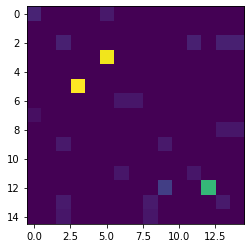

In [5]:



#%% ============================================================
# Running SpecUFEx
#%% ============================================================

specparams = config["specufexParams"]

print('Running NMF')
nmf = BayesianNonparametricNMF(X.shape)
for i in range(specparams["nmf_nbatch"]):
    # pick random sample
    print(f"Batch {i}")
#     sample = np.random.choice(X.shape[0], specparams["nmf_batchsz"])
#     nmf.fit(X[sample], verbose=0)
    nmf.fit(X, verbose=0)

print('transforming NMF')    
Vs = nmf.transform(X)
# print how long it took

#%%
print('Running HMM')
hmm = BayesianHMM(nmf.num_pat, nmf.gain)
for i in range(specparams["hmm_nbatch"]):
    print(f"Batch {i}")
#     sample = np.random.choice(Vs.shape[0], specparams["nmf_batchsz"])
    hmm.fit(Vs)

print('transforming HMM')    
fingerprints, As, gams = hmm.transform(Vs)

# print(fingerprints[0])

# show a fingerprint if you want to .. but not useful for running remotely..
plt.imshow(fingerprints[0])
plt.show()
#%%


_this took <3 hours_ 

In [7]:
# =============================================================================
# save output to H5
# =============================================================================
print('writing all output to h5')
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:


    ##fingerprints are top folder
    if 'fingerprints' in fileLoad.keys():
        del fileLoad["fingerprints"]
    fp_group = fileLoad.create_group('fingerprints')

    if 'SpecUFEX_output' in fileLoad.keys():
        del fileLoad["SpecUFEX_output"]
    out_group = fileLoad.create_group("SpecUFEX_output")

    # write fingerprints: ===============================
    for i, evID in enumerate(fileLoad['spectrograms']):
        fp_group.create_dataset(name= evID, data=fingerprints[i])


    # write the SpecUFEx out: ===========================
    # maybe include these, but they are not yet tested.
    ACM_group = fileLoad.create_group("SpecUFEX_output/ACM")
    STM_group = fileLoad.create_group("SpecUFEX_output/STM")

    for i, evID in enumerate(fileLoad['spectrograms']):
        ACM_group.create_dataset(name=evID,data=As[i]) #ACM
        STM_group.create_dataset(name=evID,data=gams[i]) #STM

    gain_group = fileLoad.create_group("SpecUFEX_output/ACM_gain")
    W_group                      = fileLoad.create_group("SpecUFEX_output/W")
    EB_group                     = fileLoad.create_group("SpecUFEX_output/EB")
    ## # # delete probably ! gain_group                   = fileLoad.create_group("SpecUFEX_output/gain")
    #RMM_group                    = fileLoad.create_group("SpecUFEX_output/RMM")

    W_group.create_dataset(name='W',data=nmf.EW)
    EB_group.create_dataset(name=evID,data=hmm.EB)
    gain_group.create_dataset(name='gain',data=nmf.gain) #same for all data
    # RMM_group.create_dataset(name=evID,data=RMM)


writing all output to h5


100000